## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import onnxruntime" || pip install -q onnxruntime
%matplotlib inline


#No need to mix the two datasets, we can do training separately on them. Or mix batches of data.
#Also compute ROI volumes. Align atlaes to the same space.

# for each roi, predict the age of the patient from that roi

## Setup imports

In [2]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, CacheDataset, Dataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from myutils import ConvertToMultiChannelHeadRecod
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Resized,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch

from mymodels import SegResNetLatentOut

print_config()

MONAI version: 1.4.0
Numpy version: 2.2.0
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/my_venv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.0
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED o

In [3]:
set_determinism(seed=0)

In [4]:
import monai
import numpy as np

class RandomConvexCombination(monai.transforms.RandomizableTransform):
    """def __init__(self, keys=[], prob=0.5):
        super().__init__()
        self.keys = keys
        self.prob = prob
    """

    def randomize(self):
        super().randomize(None)
        self._alpha = self.R.uniform(low=0, high=1)

    def __call__(self, data):
        d = dict(data)
        """for key in self.keys:
            if self.prob > 0 and self.randomize() < self.prob:
                img1 = d[key]
                img2 = d[key]  # Assuming T1 and T2 have the same key
                alpha = self.randomize()
                d["image"] = alpha * img1 + (1 - alpha) * img2
        """
        self.randomize()
        if not self._do_transform:
            return d

        d["image"] = self._alpha * d["t1_image"] + (1.0-self._alpha) * d["t2_image"]
        
        return d

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

## Setup transforms for training and validation

In [5]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["t1_image","t2_image",  "label"],allow_missing_keys=True),
        ConvertToMultiChannelHeadRecod(keys="label",allow_missing_keys=True),
        EnsureChannelFirstd(keys=["t1_image","t2_image"]),
        EnsureTyped(keys=["t1_image","t2_image", "label"],allow_missing_keys=True),
        Orientationd(keys=["t1_image","t2_image", "label"], axcodes="RAS",allow_missing_keys=True),
        Resized(keys=["t1_image","t2_image", "label"], spatial_size=[64, 64, 64], mode=("trilinear","trilinear", "nearest"),allow_missing_keys=True),
       # RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["t1_image","t2_image", "label"], prob=0.5, spatial_axis=0,allow_missing_keys=True),
        RandFlipd(keys=["t1_image","t2_image", "label"], prob=0.5, spatial_axis=1,allow_missing_keys=True),
        RandFlipd(keys=["t1_image","t2_image", "label"], prob=0.5, spatial_axis=2,allow_missing_keys=True),
        NormalizeIntensityd(keys=["t1_image","t2_image"], nonzero=True, channel_wise=True,allow_missing_keys=True),
        RandScaleIntensityd(keys=["t1_image","t2_image"], factors=0.1, prob=1.0,allow_missing_keys=True),
        RandShiftIntensityd(keys=["t1_image","t2_image"], offsets=0.1, prob=1.0,allow_missing_keys=True),
        #RandomConvexCombination()
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["t1_image","t2_image", "label"],allow_missing_keys=True),
        ConvertToMultiChannelHeadRecod(keys="label",allow_missing_keys=True),
        EnsureChannelFirstd(keys=["t1_image","t2_image"],allow_missing_keys=True),
        EnsureTyped(keys=["t1_image","t2_image", "label"],allow_missing_keys=True),
        Orientationd(keys=["t1_image","t2_image", "label"], axcodes="RAS",allow_missing_keys=True),
        #Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(2.0, 2.0, 2.0),
        #    mode=("bilinear", "nearest"),
        #),
        Resized(keys=["t1_image","t2_image", "label"], spatial_size=[64, 64, 64], mode=("trilinear", "trilinear","nearest"),allow_missing_keys=True),
        NormalizeIntensityd(keys=["t1_image","t2_image"], nonzero=True, channel_wise=True,allow_missing_keys=True),
    ]
)

In [6]:
# Load BOBs repository data
data_dir = '/home/ajoshi/project_ajoshi_27/BOBS_Repo/V1.0'
if not os.path.exists(data_dir):
    sub_data = '/project/ajoshi_27/BOBS_Repo/V1.0'

# Read tsv file
import pandas as pd
df = pd.read_csv(os.path.join(data_dir, 'participants.tsv'), sep='\t')
# Read the following comments from the tsv file : ID, Session, Age, Gestational_age_at_birth, Sex

# Read the following comments from the tsv file : ID, Session, Age, Gestational_age
df = pd.read_csv(os.path.join(data_dir, 'participants.tsv'), sep='\t')


# Display the first few rows of the dataframe
print(df.head())

t1_files = []
t2_files = []
label_files = []
ages = []
for idx, row in df.iterrows():
    t1file = os.path.join(data_dir, 'sub-'+str(row['ID']), 'ses-'+str(row['Session'])+'mo', 'anat', 'sub-'+str(row['ID'])+'_ses-'+str(row['Session'])+'mo'+'_space-INFANTMNIacpc'+'_T1w.nii.gz')

    if os.path.exists(t1file):
        t1_files.append(t1file)
    else:
        print('File not found: ', t1file)


    t2file = os.path.join(data_dir, 'sub-'+str(row['ID']), 'ses-'+str(row['Session'])+'mo', 'anat', 'sub-'+str(row['ID'])+'_ses-'+str(row['Session'])+'mo'+'_space-INFANTMNIacpc'+'_T2w.nii.gz')

    if os.path.exists(t2file):
        t2_files.append(t2file)
    else:
        print('File not found: ', t2file)

    labelfile = os.path.join(data_dir, 'sub-'+str(row['ID']), 'ses-'+str(row['Session'])+'mo', 'anat', 'sub-'+str(row['ID'])+'_ses-'+str(row['Session'])+'mo'+'_space-INFANTMNIacpc'+'_desc-aseg_dseg.nii.gz')

    if os.path.exists(labelfile):
        label_files.append(labelfile)
    else:
        print('File not found: ', labelfile)


    #t2_files.append(os.path.join(data_dir, 'sub-'+row['ID'], 'ses-'+row['Session'], 'anat', 'sub-'+row['ID']+'_ses-'+row['Session']+'_T2w.nii.gz'))
    #label_files.append(os.path.join(data_dir, 'sub-'+row['ID'], 'ses-'+row['Session'], 'anat', 'sub-'+row['ID']+'_ses-'+row['Session']+'_label.nii.gz'))
    ages.append(row['Age'])

# Display the first few rows of the dataframe
print(t1_files[:5])
print(t2_files[:5])
print(label_files[:5])
print(ages[:5])

# Load the data
data = [{"t1_image": t1, "t2_image": t2, "label": label, "age": age} for t1, t2, label, age in zip(t1_files, t2_files, label_files, ages)]
print(len(data))

# Split the data into training and validation sets
n_train = int(0.8 * len(data))
n_val = len(data) - n_train
train_data, val_data = torch.utils.data.random_split(data, [n_train, n_val])

# Create the training and validation datasets
train_ds = CacheDataset(data=train_data, transform=train_transform, cache_rate=1.0, num_workers=4)
val_ds = CacheDataset(data=val_data, transform=val_transform, cache_rate=1.0, num_workers=4)

# Create the training and validation data loaders
train_loader_bob = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
val_loader_bob = DataLoader(val_ds, batch_size=2, num_workers=4)







       ID  Session  Age  Gestational_age_at_birth     Sex
0  116056        3  3.6                      40.4    Male
1  116845        3  3.6                      37.7  Female
2  116845        6  6.5                      37.7  Female
3  176427        5  5.0                      41.7  Female
4  198202        5  5.9                      40.1    Male
['/home/ajoshi/project_ajoshi_27/BOBS_Repo/V1.0/sub-116056/ses-3mo/anat/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz', '/home/ajoshi/project_ajoshi_27/BOBS_Repo/V1.0/sub-116845/ses-3mo/anat/sub-116845_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz', '/home/ajoshi/project_ajoshi_27/BOBS_Repo/V1.0/sub-116845/ses-6mo/anat/sub-116845_ses-6mo_space-INFANTMNIacpc_T1w.nii.gz', '/home/ajoshi/project_ajoshi_27/BOBS_Repo/V1.0/sub-176427/ses-5mo/anat/sub-176427_ses-5mo_space-INFANTMNIacpc_T1w.nii.gz', '/home/ajoshi/project_ajoshi_27/BOBS_Repo/V1.0/sub-198202/ses-5mo/anat/sub-198202_ses-5mo_space-INFANTMNIacpc_T1w.nii.gz']
['/home/ajoshi/project_ajoshi_27/BOB

Loading dataset: 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


## Check data shape and visualize

image shape: torch.Size([1, 64, 64, 64])
image shape: torch.Size([1, 64, 64, 64])


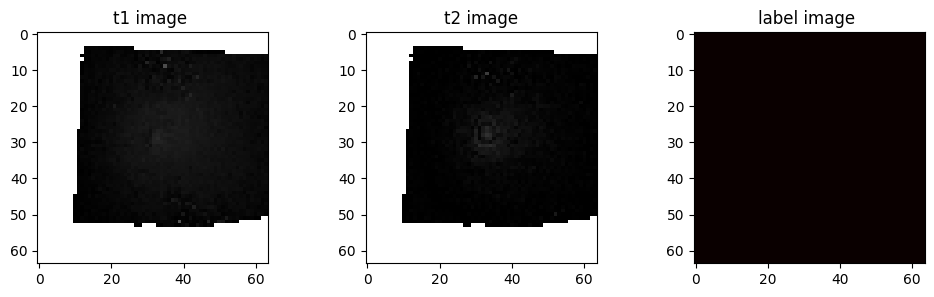

age: 5.4
image shape: torch.Size([1, 64, 64, 64])
image shape: torch.Size([1, 64, 64, 64])


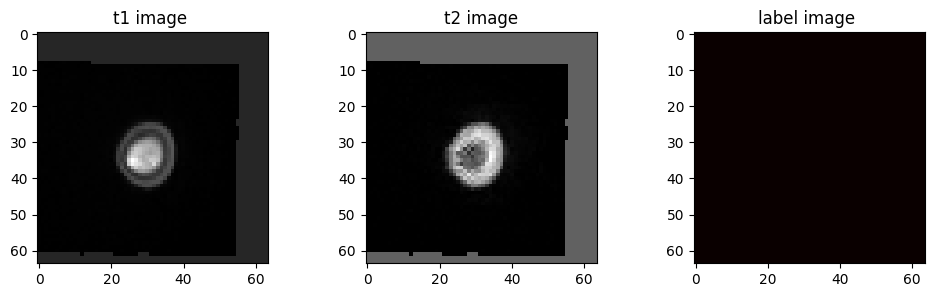

age: 8.7
image shape: torch.Size([1, 64, 64, 64])
image shape: torch.Size([1, 64, 64, 64])


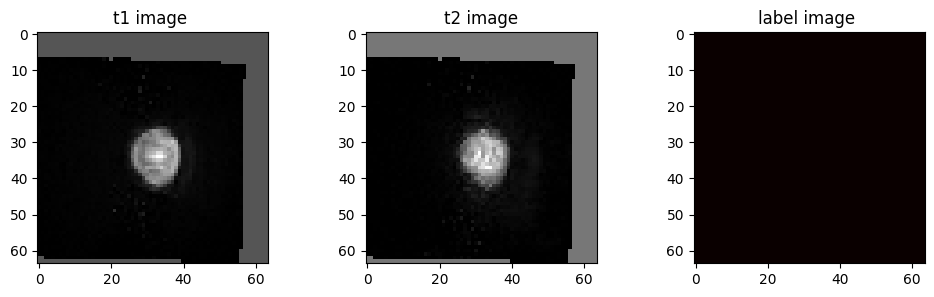

age: 7.4
image shape: torch.Size([1, 64, 64, 64])
image shape: torch.Size([1, 64, 64, 64])


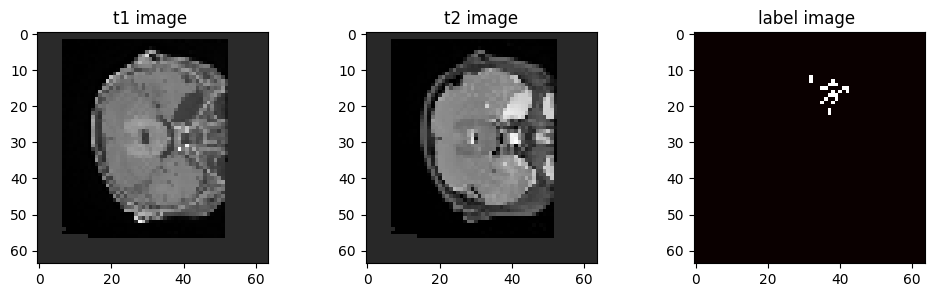

age: 8.8
image shape: torch.Size([1, 64, 64, 64])
image shape: torch.Size([1, 64, 64, 64])


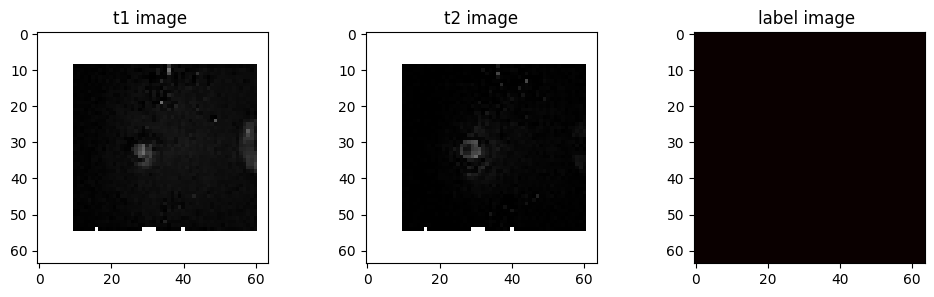

age: 1.8


In [7]:
for jj in range(5):
    val_data_example = train_ds[jj]
    print(f"image shape: {val_data_example['t1_image'].shape}")
    print(f"image shape: {val_data_example['t2_image'].shape}")
    #print(val_data_example.get('age', None))

    plt.figure("t1 and t2 images", (12, 3))
    plt.subplot(1, 3, 1)
    plt.title(f"t1 image ")
    plt.imshow(val_data_example["t1_image"][0, :, :, 48].detach().cpu(), cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"t2 image")
    plt.imshow(val_data_example["t2_image"][0, :, :, 48].detach().cpu(), cmap="gray")
    plt.subplot(1, 3, 3)
    plt.title(f"label image ")
    plt.imshow(val_data_example["label"][1, :, :, 48].detach().cpu(), cmap="hot")
    plt.show()
    print(f"age: {val_data_example['age']}")






## Create Model, Loss, Optimizer

In [8]:
max_epochs = 300
val_interval = 5
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNetLatentOut(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=8,
    in_channels=1,
    out_channels=2,
    dropout_prob=0.2,
).to(device)


# at the latent layter, add a small neural network to predict brain age
#model.add_module("fc1", torch.nn.Linear(512, 1))


loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

/tmp/ipykernel_14866/908971095.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## Execute a typical PyTorch training process

In [9]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader_bob:
        step_start = time.time()
        step += 1
        inputs = batch_data["t1_image"].to(device)
        print(inputs.shape)
        print(inputs)
        labels = batch_data.get("label")
        #.to(device) #torch.zeros_like(inputs)
        age = batch_data.get("age").to(device)
        print(f"age: {age}")
        #continue
        """if labels is None:
            labels = torch.zeros_like(inputs)
        if age is None:
            age = torch.zeros(inputs.size(0), device=device)
        """
        optimizer.zero_grad()


        with torch.cuda.amp.autocast():
            #inputs.shape
            #model(inputs)
            outputs, out_age = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader_bob.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader_bob:
                val_inputs, val_labels = (
                    val_data["t1_image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/300
torch.Size([2, 1, 64, 64, 64])
metatensor([[[[[-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903],
           [-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903],
           [-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903],
           ...,
           [-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903],
           [-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903],
           [-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903]],

          [[-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903],
           [-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903],
           [-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903],
           ...,
           [-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903],
           [-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903],
           [-0.0903, -0.0903, -0.0903,  ..., -0.0903, -0.0903, -0.0903]],

          [[-0.0903, -0.0903, 

/tmp/ipykernel_14866/1002310890.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


AssertionError: ground truth has different shape (torch.Size([2, 3, 64, 64, 64])) from input (torch.Size([2, 2, 64, 64, 64]))

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

## Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Check best pytorch model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (96, 96, 96)
    sw_batch_size = 4
    val_output = inference(val_input)
    print('shape of labels ',val_ds[6]["label"].shape)


    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(1):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 48].detach().cpu(), cmap="gray")
    plt.show()
    
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 48].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 48].detach().cpu())
    plt.show()

## Evaluation on original image spacings

In [ ]:
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        ConvertToMultiChannelHeadRecod(keys="label"),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(2.0, 2.0, 2.0),
        #    mode=("bilinear", "nearest"),
        #),
        Resized(keys=["image", "label"], spatial_size=[96, 96, 96], mode=("trilinear", "nearest")),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        ConvertToMultiChannelHeadRecod(keys="label"),
        #EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Resized(keys=["image"], spatial_size=[96, 96, 96], mode=("trilinear")),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

# val_ds = CacheDataset(data=val_files, transform=val_transform, cache_rate=1.0, num_workers=4)
val_org_ds = Dataset(data=val_files, transform=val_transform)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image1",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
device = 'cuda:0'
with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        print('shape of labels ',val_data["label"].shape)
        val_data = decollate_batch(val_data)
        print('shape of labels ',len(val_data))
        val_data = [post_transforms(i) for i in val_data]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

## Convert torch to onnx model

In [ ]:
dummy_input = torch.randn(1, 4, 240, 240, 160).to(device)
onnx_path = os.path.join(root_dir, "best_metric_model.onnx")
torch.onnx.export(model, dummy_input, onnx_path, verbose=False)

## Inference onnx model
Here we change the model used by predictor to onnx_infer, both of which are used to obtain a tensor after the input has been reasoned by the neural network.

Note: If the warning `pthread_setaffinity_np failed` appears when executing this cell, this is a known problem with the onnxruntime and does not affect the execution result. If you want to disable the warning, you can cancel the following comment to solve the problem.

In [ ]:
# Using the following program snippet will not affect the execution time.
# options = ort.SessionOptions()
# options.intra_op_num_threads = 1
# options.inter_op_num_threads = 1

In [ ]:
def onnx_infer(inputs):
    ort_inputs = {ort_session.get_inputs()[0].name: inputs.cpu().numpy()}
    ort_outs = ort_session.run(None, ort_inputs)
    return torch.Tensor(ort_outs[0]).to(inputs.device)


def predict(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=onnx_infer,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

In [ ]:
onnx_model_path = os.path.join(root_dir, "best_metric_model.onnx")
ort_session = onnxruntime.InferenceSession(onnx_model_path)

for val_data in tqdm(val_loader, desc="Onnxruntime Inference Progress"):
    val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
    )

    ort_outs = predict(val_inputs)
    val_outputs = post_trans(torch.Tensor(ort_outs[0]).to(device)).unsqueeze(0)

    dice_metric(y_pred=val_outputs, y=val_labels)
    dice_metric_batch(y_pred=val_outputs, y=val_labels)
onnx_metric = dice_metric.aggregate().item()
onnx_metric_batch = dice_metric_batch.aggregate()
onnx_metric_tc = onnx_metric_batch[0].item()
onnx_metric_wt = onnx_metric_batch[1].item()
onnx_metric_et = onnx_metric_batch[2].item()

print(f"onnx metric: {onnx_metric}")
print(f"onnx_metric_tc: {onnx_metric_tc:.4f}")
print(f"onnx_metric_wt: {onnx_metric_wt:.4f}")
print(f"onnx_metric_et: {onnx_metric_et:.4f}")

## Check best onnx model output with the input image and label

In [ ]:
onnx_model_path = os.path.join(root_dir, "best_metric_model.onnx")
ort_session = onnxruntime.InferenceSession(onnx_model_path)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    ort_output = predict(val_input)
    ort_output = post_trans(torch.Tensor(ort_output[0]).to(device)).unsqueeze(0)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"pth output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"onnx output channel {i}")
        plt.imshow(ort_output[0, i, :, :, 70].detach().cpu())
    plt.show()